In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [136]:
df = pd.read_csv('../data/iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [137]:
X = df.drop('species', axis = 1)
y = df['species']
print(X.shape, y.shape)

(150, 4) (150,)


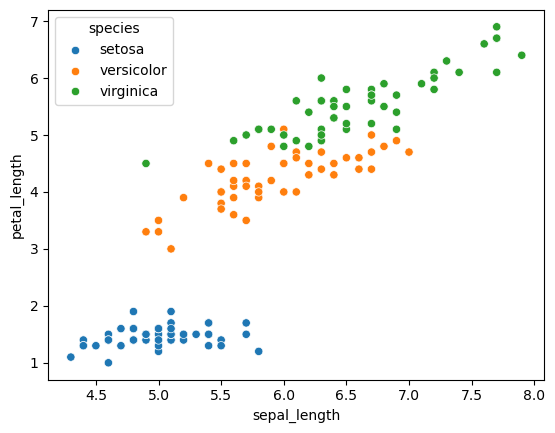

In [138]:
sns.scatterplot(data = df, x = 'sepal_length', y = 'petal_length', hue = 'species');

In [139]:
df['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

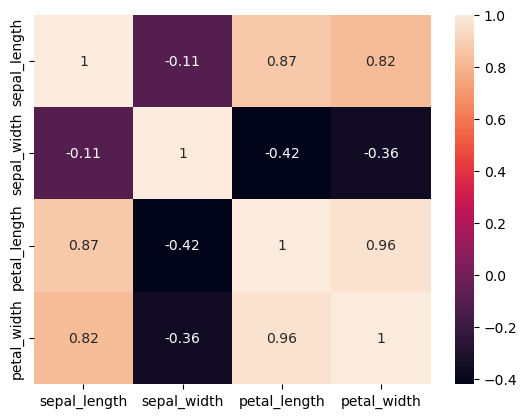

In [140]:
sns.heatmap(df.corr(numeric_only=True), annot= True);

In [141]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(105, 4) (45, 4) (105,) (45,)


In [142]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(np.min(X_train[:, 0]), np.max(X_train[:, 0]))
print(np.mean(X_train[:, 0]), np.std(X_train[:, 0]))

-1.8355104968329878 2.444705220643072
-2.439847266021475e-16 1.0


In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [144]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='deprecated', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-c

In [145]:
model = LogisticRegression(solver = 'saga', multi_class='ovr', max_iter = 5000)

In [146]:
# Penalty Type
penalty = ['l1', 'l2']

# Use logarithmically spaced C values (recommended in official docs)
C = np.logspace(0, 4, 10)
grid_model = GridSearchCV(model,param_grid={'C':C,'penalty':penalty})
grid_model.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [147]:
grid_model.best_params_

{'C': 21.544346900318832, 'penalty': 'l1'}

In [148]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix

In [149]:
preds = grid_model.predict(X_test)
print(preds)
accuracy = accuracy_score(y_test, preds)
print(accuracy)

['setosa' 'setosa' 'setosa' 'virginica' 'versicolor' 'virginica'
 'versicolor' 'versicolor' 'virginica' 'setosa' 'virginica' 'setosa'
 'setosa' 'virginica' 'virginica' 'versicolor' 'versicolor' 'versicolor'
 'setosa' 'versicolor' 'versicolor' 'setosa' 'versicolor' 'versicolor'
 'versicolor' 'versicolor' 'versicolor' 'virginica' 'setosa' 'setosa'
 'virginica' 'versicolor' 'virginica' 'versicolor' 'virginica'
 'versicolor' 'versicolor' 'versicolor' 'versicolor' 'virginica' 'setosa'
 'setosa' 'setosa' 'virginica' 'versicolor']
0.9555555555555556


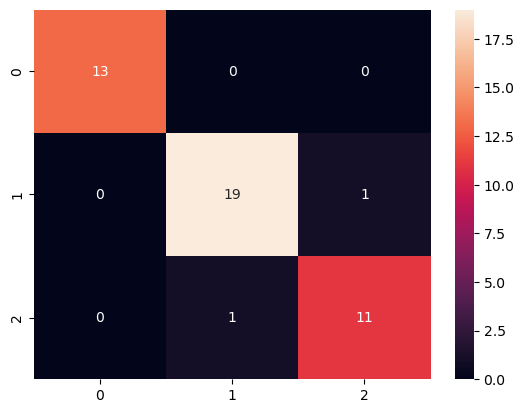

In [150]:
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt = 'd');

In [151]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.95      0.95      0.95        20
   virginica       0.92      0.92      0.92        12

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



In [152]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

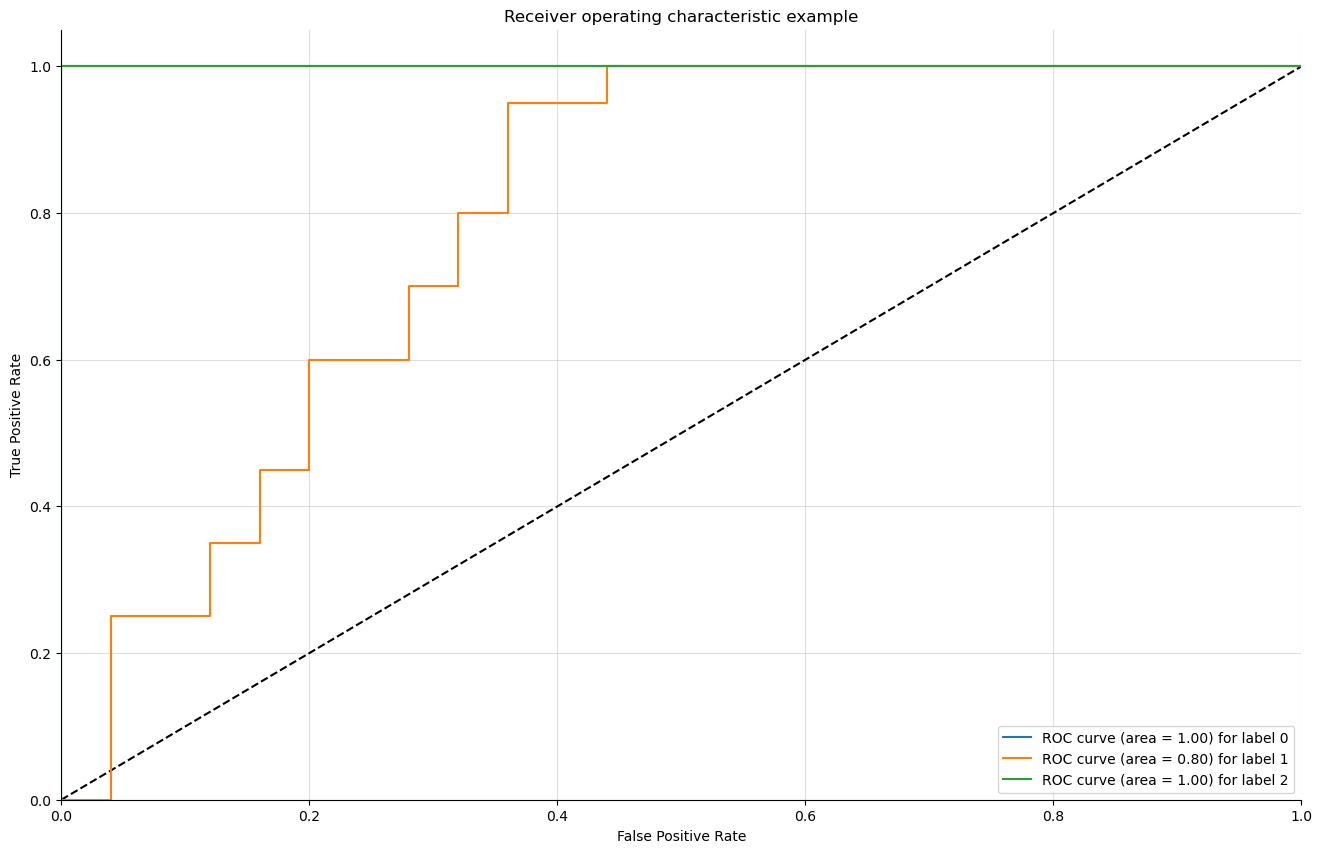

In [153]:
plot_multiclass_roc(grid_model, X_test, y_test, n_classes = 3, figsize = (16, 10))